In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [69]:
from scipy import stats
import matplotlib.pyplot as plt

'''
Function that takes in two dataframe columns and plots a log-log graph
Follows standardised formatting
@input recorded: dataframe column of recorded data
@input predicted: dataframe column of the predicted value
@input xmin: lower bound of graph's x axis
@input xmax: upper bound of graph's x axis
@input ymin: lower bound of graph's y axis
@input ymax: upper bound of graph's y axis
@input xTitle: title for x axis
@input yTitle: title for y axis
@output log log graph of the preducted values against recorded values
'''

def logLogPlotter(recorded, predicted, xmin, xmax, ymin, ymax, xTitle, yTitle, units):
    x = recorded
    y = predicted

    coefficients = np.polyfit(np.log(x), np.log(y), 1)
    line_function = np.poly1d(coefficients)

    # Create a range for predicted values for the fit line
    x_vals = np.linspace(min(x), max(y), 400)
    y_vals = np.exp(line_function(np.log(x_vals)))

    #calculate similarity measures
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    #best fit line and y = x line
    plt.scatter(x, y, c='red', marker='x')
    plt.plot(x_vals, y_vals, color='red', label=f'Fit: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
    plt.axline((0, 0), (1,1),color='black',linestyle='--', label=f'y=x, R^2 = {r_value ** 2}',)

    #visuals
    font_family = 'Times New Roman'
    title_font_size=17
    label_font_size=15
    legend_tick_font_size=12

    plt.title(f'Predicted {yTitle} against Recorded {xTitle}', fontsize=title_font_size, fontfamily=font_family)
    plt.xlabel(f'Recorded {xTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)
    plt.ylabel(f'Predicted {yTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)

    plt.legend(fontsize = legend_tick_font_size)
    plt.loglog()
    plt.xlim(xmax=xmax, xmin=xmin)
    plt.ylim(ymax=ymax, ymin=ymin)

    plt.show()

In [2]:
data = pd.read_csv('../data/task2.1data.csv')
data[:5]

,M,air_temp,load_resistance,i_d,output_voltage,power_output
0,0.0,10.0,200.0,24.3,46.0,87.3
1,1.0,10.0,200.0,24.3,27.9,64.2
2,2.0,10.0,200.0,24.3,27.9,32.1
3,0.0,10.0,200.0,51.8,46.0,40.9
4,1.0,10.0,200.0,51.8,92.1,163.9


## Median values

In [3]:
data.median()

M                    1.00
air_temp            10.00
load_resistance    600.00
i_d                 27.45
output_voltage      55.15
power_output       170.55
dtype: float64

In [9]:
median_values = data.median()

In [10]:
air_temp_med = median_values[1]
load_resistance_med = median_values[2]
i_d_med = median_values[3]
output_voltage_med = median_values[4]
power_output_med = median_values[5]

## Normalization

In [6]:
#we can just call this and not worry about M since the median for M is 1.
data = data.divide(data.median())
data[:5]

,M,air_temp,load_resistance,i_d,output_voltage,power_output
0,0.0,1.0,0.333333,0.885246,0.834089,0.511873
1,1.0,1.0,0.333333,0.885246,0.505893,0.376429
2,2.0,1.0,0.333333,0.885246,0.505893,0.188215
3,0.0,1.0,0.333333,1.887067,0.834089,0.239812
4,1.0,1.0,0.333333,1.887067,1.669991,0.961009


## Training and Validation set split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = data[['M', 'air_temp', 'load_resistance', 'i_d']]
y = data[['output_voltage', 'power_output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42)


In [12]:
'''>>>>> start CodeP3.1.2F23
    V.P. Carey ME249, Fall 2023

Intro to Neural Network Modeling 
Keras model for PV power system'''

#import useful packages
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf
#the follwoing 2 lines are only needed for Mac OS machines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# define meadian values of input variables - add your values here
Tamed = air_temp_med  #make sure Tamed does not = 0
IDmed = i_d_med
RLmed = load_resistance_med

#Part 1 input data: Air temp (degC), ID (W/sqm), load resistance (ohms)
xdata = X_train
xarray= np.array(xdata)
# print (xdata)
# print (xarray)

# define meadian values of output variables - add your values here
VLmed = output_voltage_med
Wdmed = power_output_med

#create output data array
ydata = y_train
yarray= np.array(ydata)
# print (ydata)
# print (yarray)

In [62]:
# define neural network model

#As seen below, we have created four dense layers. 
#A dense layer is a layer in neural network that’s fully connected. 
#In other words, all the neurons in one layer are connected to all other neurons in the next layer.
#In the first layer, we need to provide the input shape, which is 1 in our case. 
#The activation function we have chosen is elu, which stands for exponential linear unit. .

from keras import backend as K
#initialize weights with values between -0.2 and 0.5
initializer = keras.initializers.RandomUniform(minval= -0.5, maxval=0.5)

model = keras.Sequential([
keras.layers.Dense(13, activation=K.elu, input_shape=[4], kernel_initializer=initializer),
keras.layers.Dense(26, activation=K.elu, kernel_initializer=initializer),
keras.layers.Dense(13, activation=K.elu, kernel_initializer=initializer),
keras.layers.Dense(2, kernel_initializer=initializer)
])


In [63]:
#We’re using RMSprop as our optimizer here. RMSprop stands for Root Mean Square Propagation. 
#It’s one of the most popular gradient descent optimization algorithms for deep learning networks. 
#RMSprop is an optimizer that’s reliable and fast.
#We’re compiling the mode using the model.compile function. The loss function used here 
#is mean squared error. After the compilation of the model, we’ll use the fit method with ~500 epochs.
#Number of epochs can be varied.

#from tf.keras import optimizers
rms = keras.optimizers.RMSprop(0.020)
model.compile(loss='mean_absolute_error',optimizer=rms)


In [64]:
#After the compilation of the model, we’ll use the fit method with 500 epochs.
#I started with epochs value of 100 and then tested the model after training. 
#The prediction was not that good. Then I modified the number of epochs to 200 and tested the model again. 
#Accuracy had improved slightly, but figured I’d give it one more try. Finally, at 500 epochs 
#I found acceptable prediction accuracy.

#The fit method takes three parameters; namely, x, y, and number of epochs. 
#During model training, if all the batches of data are seen by the model once, 
#we say that one epoch has been completed.

# Add an early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='loss', 
    mode='min', 
    patience = 80, 
    restore_best_weights = True, 
    verbose=1)
# Add a checkpoint where loss is minimum, and save that model
mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='loss', 
                     mode='min',  verbose=1, save_best_only=True)

historyData = model.fit(xarray,yarray,epochs=1200,callbacks=[es])

loss_hist = historyData.history['loss']
#The above line will return a dictionary, access it's info like this:
best_epoch = np.argmin(historyData.history['loss']) + 1
print ('best epoch = ', best_epoch)

print('smallest loss =', np.min(loss_hist))

# model.save('best_model.h5')

Epoch 1/1200
36/36 [==============================] - 0s 9ms/step - loss: 1.6600
Epoch 2/1200
36/36 [==============================] - 0s 99us/step - loss: 1.2017
Epoch 3/1200
36/36 [==============================] - 0s 375us/step - loss: 0.7858
Epoch 4/1200
36/36 [==============================] - 0s 339us/step - loss: 0.8380
Epoch 5/1200
36/36 [==============================] - 0s 185us/step - loss: 0.8255
Epoch 6/1200
36/36 [==============================] - 0s 151us/step - loss: 0.9018
Epoch 7/1200
36/36 [==============================] - 0s 390us/step - loss: 1.4263
Epoch 8/1200
36/36 [==============================] - 0s 313us/step - loss: 0.7929
Epoch 9/1200
36/36 [==============================] - 0s 325us/step - loss: 1.0414
Epoch 10/1200
36/36 [==============================] - 0s 520us/step - loss: 1.0228
Epoch 11/1200
36/36 [==============================] - 0s 297us/step - loss: 0.8818
Epoch 12/1200
36/36 [==============================] - 0s 228us/step - loss: 0.8832
Epoc

In [65]:
y_predictions = model.predict(X_train[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.752627,0.161174
1,1.255606,1.635358
2,0.886816,0.260546
3,1.609304,1.826296
4,1.184039,0.816046
5,1.147560,0.427008
6,0.974545,0.626524
7,0.821952,0.103904
8,3.075430,2.963597
9,1.479158,1.648884


In [66]:
y_recorded_df = y_train[['output_voltage', 'power_output']]
y_recorded_df


,output_voltage,power_output
6,0.834089,0.128994
39,0.921124,1.294049
33,0.894016,0.257403
13,0.377153,0.728819
17,1.144152,1.103489
45,0.921124,0.363530
15,0.877607,0.649077
9,0.834089,0.072706
16,1.755213,2.596892
29,1.082502,1.464673


In [67]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.5821799143035817


/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


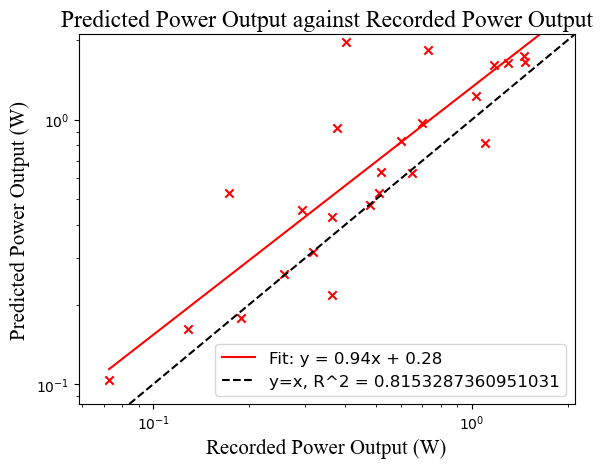

In [70]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 2.1, -0.5, 2.1, 'Power Output', 'Power Output', 'W')